In [23]:
import pandas as pd 
import numpy as np
import pickle
import matplotlib as plt
import random 

Below we artifically generate data by doing the following: 
1. Take all 2 minute segments with an acceptable kappa score 
2. Reserve a testing set (30 samples minimum). This will prevent data leakage. 
3. For both edges (12 per meeting) and nodes (4 per meeting):
    1. Fit remaning data using a GMM finding the number of components that maximize the suilhouette score. 
    2. Assign each sample a profile number, based on what component it corresponds to.
    3. Generate an additional GMM for each edge/node profile to sample from. 
4. Group Samples by meeting and start time, such that each group contains 12 edges and 4 nodes. 
5. Regenerate each group n times by randomly sampling each generates node/edge from its corresponding profile's GMM. 
6. Finalize training/validation set by combining artifically generated meetings with real ones. Append a "Generated ID" to identify 
Generated meetings and assign higher weaits or apply further data processing if need be. 


Lets first read in the graph data

In [24]:
with open('data/graphs_cohesion_data_generation.pkl', 'rb') as f:
    graphs_cohesion_data = pickle.load(f)

print(f'Number of meetings graphs: {len(graphs_cohesion_data)}')


Number of meetings graphs: 1978


Lets now read in cohesion annotation data for both questions and categories

In [25]:
category_level_df = pd.read_pickle("../Cohesion_Annotations/Cohesion_split_data.pkl")
category_level_df['Start'] = category_level_df['Start'] * 60
category_level_df['End'] = category_level_df['End'] * 60
print('Number of segments annotated for cohesion categories: ', len(category_level_df))

Number of segments annotated for cohesion categories:  120


In [26]:
question_level_df = pd.read_pickle("../Cohesion_Annotations/Question_split_data.pkl")
question_level_df['Start'] = question_level_df['Start'] * 60
question_level_df['End'] = question_level_df['End'] * 60
print('Number of segments annotated for cohesion questions: ', len(question_level_df))

Number of segments annotated for cohesion questions:  120


Lets join both datasets for simpliccity managing it

In [27]:
# Perform a left join on 'meeting' and 'start' columns to merge category_level_df into node_df
annotations_df = pd.merge(category_level_df, question_level_df, 
                on=['Meeting', 'Start', 'End'], how='inner')
print("Number of question/cohesion rows (should be 120):", len(annotations_df))


Number of question/cohesion rows (should be 120): 120


ok, now that we have the annotations data consolidated lets, first write a function that uses this data, a category/question paraeter, and a roof annd ceiling, to set aside testing and training data. 

In [28]:
def get_test_train_split(category_kappa=(None, None), question_std=(None, None), minimum_high_score=4.5, maximum_low_score=3.5):
    # first we filter out entries in the data frame and assign binary labels
    filtered_df = annotations_df.copy()

    if category_kappa != (None, None):
        filtered_df = filtered_df[((filtered_df[f'{category_kappa[0]}_Average'] >= minimum_high_score) | (filtered_df[f'{category_kappa[0]}_Average'] < maximum_low_score)) 
                    & (filtered_df[f'{category_kappa[0]}_Kappa'] >= category_kappa[1])]
        
        #  lets now assign binary labels 
        filtered_df['binary_label'] = np.where(filtered_df[f'{category_kappa[0]}_Average'] < maximum_low_score, 0, 
                                        np.where(filtered_df[f'{category_kappa[0]}_Average'] >= minimum_high_score, 1, np.nan))
        
    elif question_std != (None, None): 
        filtered_df = filtered_df[((filtered_df[f'{question_std[0]}_mean'] >= minimum_high_score) | (filtered_df[f'{question_std[0]}_mean'] < maximum_low_score)) 
                    & (filtered_df[f'{question_std[0]}_std'] <= question_std[1])]
        #  lets now assign binary labels 
        filtered_df['binary_label'] = np.where(filtered_df[f'{question_std[0]}_mean'] < maximum_low_score, 0, 
                                        np.where(filtered_df[f'{question_std[0]}_mean'] >= minimum_high_score, 1, np.nan))
    else:
        print("please enter df parameters.")
        return
    

    # Split graphs into graphs_within_constraints and other_graphs based on meeting and start time in the same row of filtered_df
    graphs_within_constraints = []
    for graph in graphs_cohesion_data:
        matching_row = filtered_df[(filtered_df['Meeting'] == graph['meeting']) & (filtered_df['Start'] == graph['start'])]
        if not matching_row.empty:
            graph['score'] = matching_row['binary_label'].values[0]  # Assign binary label as score
            graphs_within_constraints.append(graph)
    
    other_graphs = [graph for graph in graphs_cohesion_data if graph not in graphs_within_constraints]


    # Randomly split other_graphs into testing and training_base
    random.shuffle(graphs_within_constraints)
    split_index = int(len(graphs_within_constraints) * 0.7) 
    training_base = graphs_within_constraints[:split_index]
    testing = graphs_within_constraints[split_index:]

    print(f'Binary Label Distribution Testing: ')
    print(f'Number of 1s: {len([test for test in testing if test["score"] == 1])}')
    print(f'Number of 0s: {len([test for test in testing if test["score"] == 0])} \n')

    print(f'Binary Label Distribution Training_base: ')
    print(f'Number of 1s: {len([train for train in training_base if train["score"] == 1])}')
    print(f'Number of 0s: {len([train for train in training_base if train["score"] == 0])} \n')
    


    # Combine other_graphs with training_base to create list of graphs used to identify deifferent node/edge profiles. 
    GMM_data = training_base + other_graphs

    # Return testing, distribution_base, and filtered_df
    return testing, training_base, GMM_data, filtered_df
    
    


In [29]:
def graph_nodes_df_convert(graphs):
    rows = []
    # Iterate through each data point
    for item in graphs:
        meeting = item['meeting']
        start_time = item['start']
        features = item['features'][0]  # Only node features, ignoring edge features
        
        # For each speaker, we will create a row in the final dataframe
        for speaker, speaker_features in features.items():
            row = {'Meeting': meeting, 'Start': start_time, 'speaker': speaker}
            for feature_name, value in speaker_features:
                row[feature_name] = value
            rows.append(row)

    # Create a dataframe from the list of rows
    node_df = pd.DataFrame(rows)
    return node_df

In [30]:
import pandas as pd

def graph_edges_df_convert(graphs):
    # Prepare an empty list to store each edge's data as a row
    edge_rows = []

    # Iterate through each meeting in the data
    for item in graphs:
        meeting = item['meeting']
        start_time = item['start']
        edge_features = item['features'][1]  # Only edge features, ignoring node features
        
        # For each edge (e.g., 'A,B'), extract the speaker and target, along with the features
        for edge, features in edge_features.items():
            speaker, speaker_target = edge.split(',')  # Split the edge identifier to get speaker and target
            
            # Create a row for this edge with the 3 edge features
            row = {
                'Meeting': meeting,
                'Start': start_time,
                'speaker': speaker,
                'speaker_target': speaker_target
            }
            
            # Add the 3 edge features to the row
            for feature_name, value in features:
                row[feature_name] = value
            
            edge_rows.append(row)

    # Create a DataFrame from the list of edge rows
    edge_df = pd.DataFrame(edge_rows)

    return edge_df


In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

node_features_columns = [
        'time_portion', 'speaking_turns_proportion', 'rate_of_speech', 'lexical_richness',
        'positive_sentiment_proportion', 'negative_sentiment_proportion', 'average_word_rarity',
        'first_person_pronoun_usage', 'second_person_pronoun_usage', 'third_person_pronoun_usage',
        'agreement_words_proportion', 'disagreement_words_proportion'
    ]

def get_node_GMM(node_df):
# Assuming df is the DataFrame you have, with all the speaker features
# List of feature columns that are numeric and relevant for GMM

    best_score = -1.0
    best_nodes_gmm = None
    best_profiles = None

    # Extract the feature values from the dataframe
    X_nodes = node_df[node_features_columns].values

    for i in range(2,6):

        # Fit a Gaussian Mixture Model (GMM) to the speaker features
        gmm_nodes = GaussianMixture(n_components=i)  
        gmm_nodes.fit(X_nodes)

        # Predict the profile for each speaker based on the features
        profiles_nodes = gmm_nodes.predict(X_nodes)

        # Calculate silhouette score
        score = silhouette_score(X_nodes, profiles_nodes)

        if score > best_score:
            best_nodes_gmm = gmm_nodes
            best_score = score
            best_profiles = profiles_nodes

    print(f"Best Silhouette Score for node features: {best_score}")
    # set profiles before returning 
    node_df['profile'] = best_profiles
    return best_nodes_gmm



In [32]:

edge_features_columns = ['LSM', 'interruptions', 'average_turns_between']

def get_edge_GMM(edge_df):

    best_score = -1.0
    best_edges_gmm = None
    best_profiles = None

    # Extract the feature values from the dataframe
    X_edges = edge_df[edge_features_columns].values

    for i in range(2,6):

        # Fit a Gaussian Mixture Model (GMM) to the speaker features
        gmm_edges = GaussianMixture(n_components=i)  # You can adjust the n_components for the number of profiles
        gmm_edges.fit(X_edges)

        # Predict the profile for each speaker based on the features
        edge_profiles = gmm_edges.predict(X_edges)

        # Calculate silhouette score
        score= silhouette_score(X_edges, edge_profiles)

        if score > best_score:
            best_edges_gmm = gmm_edges
            best_score = score
            best_profiles = edge_profiles

    print(f"Best Silhouette Score for edge features: {best_score}")
    # set profiles before returning 
    edge_df['profile'] = best_profiles
    return best_edges_gmm

In [33]:
import matplotlib.pyplot as plt
def plot_label_hist(df):
    # Assuming 'profile' is the column in the dataframe that contains the profile assignments
    # Plotting the histogram
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    df['profile'].value_counts().sort_index().plot(kind='bar', color='skyblue')

    # Adding title and labels
    plt.title('Frequency of Profiles', fontsize=16)
    plt.xlabel('Profile', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Display the plot
    plt.show()

below we define the group of graphs used to:
- Generate artifical data (distribution_base), 
- Test the model (training data)

We also keep the filtered data containing all meetings that fit within user parameters (will be used later)

We convert the edge and node features from the ditribution base into dfs for easier handling and define the optiamal GMM profiles for each. 
Lastly we generate distributions for each. 

Binary Label Distribution Testing: 
Number of 1s: 5
Number of 0s: 10 

Binary Label Distribution Training_base: 
Number of 1s: 16
Number of 0s: 17 

Size of GMM_data (training_base + non_annotated_data):  1963
Best Silhouette Score for node features: 0.6343841811037155
Best Silhouette Score for edge features: 0.1143260426684094

Node Feature Profile Distributions:


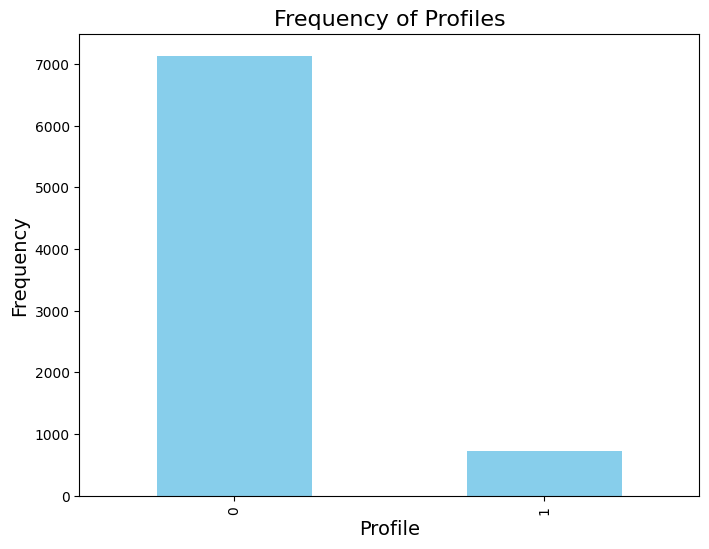

Edgee Feature Profile Distributions:


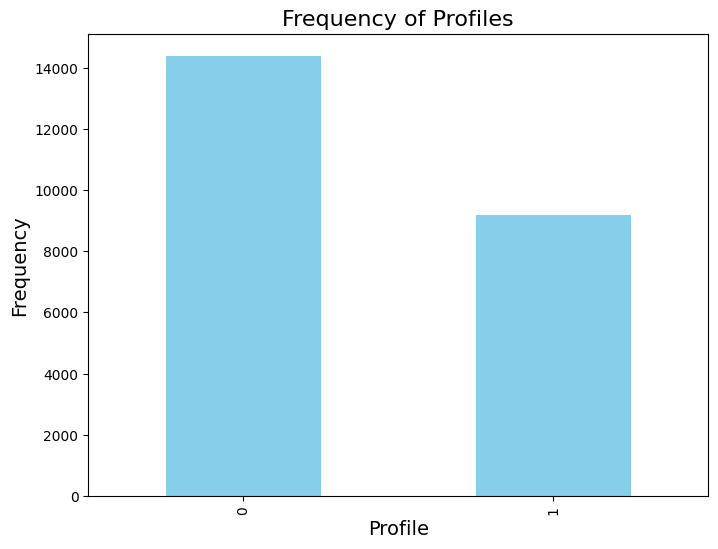

In [34]:
testing, training_base, GMM_data, filtered_df = get_test_train_split(category_kappa=(None, None), question_std=('M1', 0.1), maximum_low_score=1.5, minimum_high_score=1.5)
print('Size of GMM_data (training_base + non_annotated_data): ', len(GMM_data))
# save training and testing base separatley 
# Assuming 'graphs' is your list of graph data
with open('data/graphs_cohesion_data_training_base.pkl', 'wb') as f:
    pickle.dump(training_base, f)
with open('data/graphs_cohesion_data_testing.pkl', 'wb') as f:
    pickle.dump(testing, f)

node_df = graph_nodes_df_convert(GMM_data)
edge_df = graph_edges_df_convert(GMM_data)
node_gmm = get_node_GMM(node_df)
edge_gmm = get_edge_GMM(edge_df)
print("\nNode Feature Profile Distributions:")
plot_label_hist(node_df)
print("Edgee Feature Profile Distributions:")
plot_label_hist(edge_df)

In [35]:
def merge_nodes_edges_with_labels(node_df, edge_df, filtered_df): 
    node_df = pd.merge(node_df, filtered_df[['Meeting', 'Start', 'binary_label']], 
                    on=['Meeting', 'Start'], how='inner')
    edge_df = pd.merge(edge_df, filtered_df[['Meeting', 'Start', 'binary_label']], 
                    on=['Meeting', 'Start'], how='inner')
    
    return node_df, edge_df

In [36]:
node_df, edge_df = merge_nodes_edges_with_labels(node_df, edge_df, filtered_df)
print(f'Length of node_df (should equal {len(training_base) * 4}): {len(node_df)}')
print(f'Length of edge_df (should equal {len(training_base) * 12}): {len(edge_df)}')

Length of node_df (should equal 132): 132
Length of edge_df (should equal 396): 396


Very promising stuff. There are in fact different node profiles depending on cohesion levels, so i should be able to succesfully sample. 

Number of low-cohesion nodes:  68


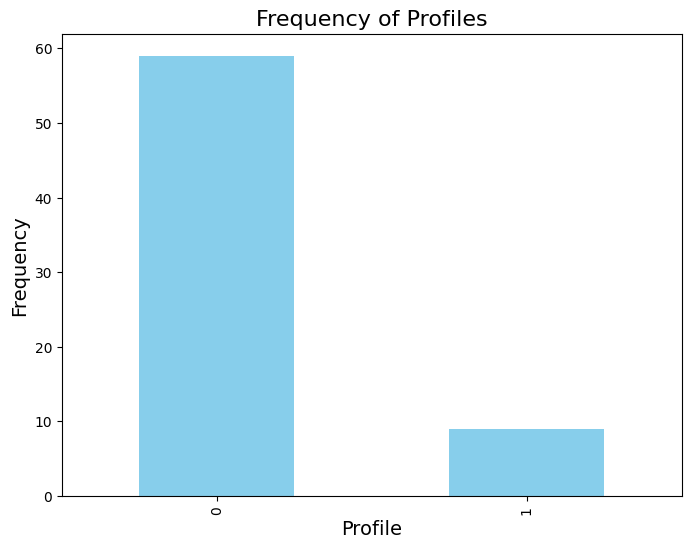

Number of high-cohesion nodes:  64


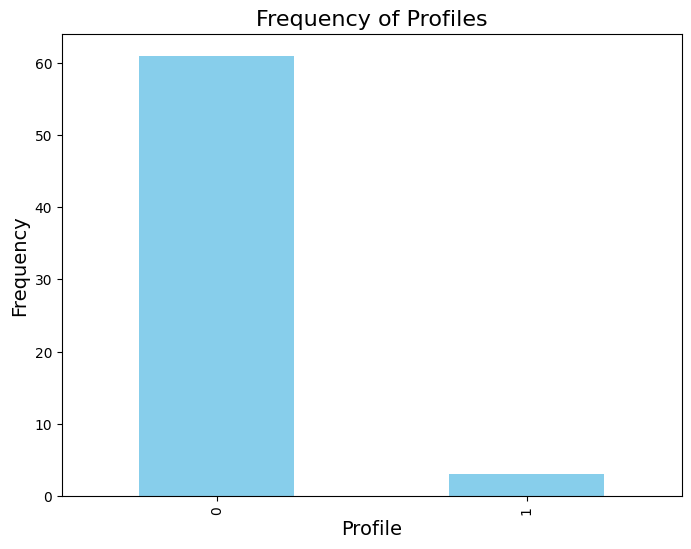

In [37]:
node_df_low = node_df[node_df['binary_label'] == 0.0]
node_df_high = node_df[node_df['binary_label'] == 1.0]
print('Number of low-cohesion nodes: ', len(node_df_low))
plot_label_hist(node_df_low)
print('Number of high-cohesion nodes: ', len(node_df_high))
plot_label_hist(node_df_high)

Edges also seem to show different profile distributions dependning on degree of cohesion 

Number of low-cohesion edges:  204


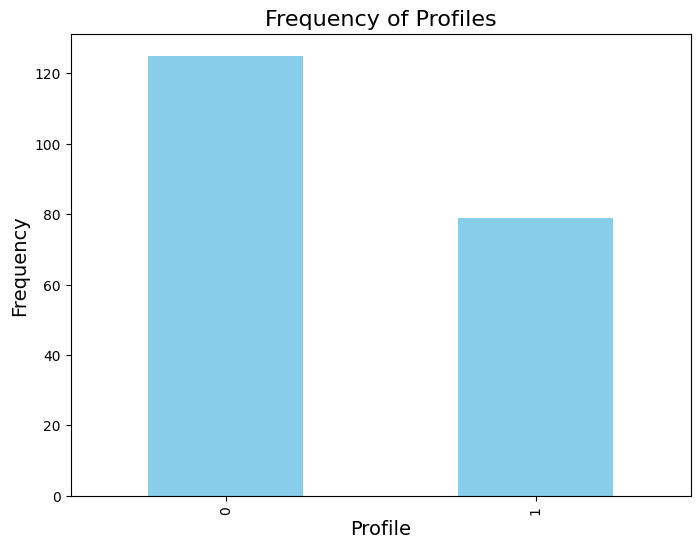

Number of high-cohesion edges:  192


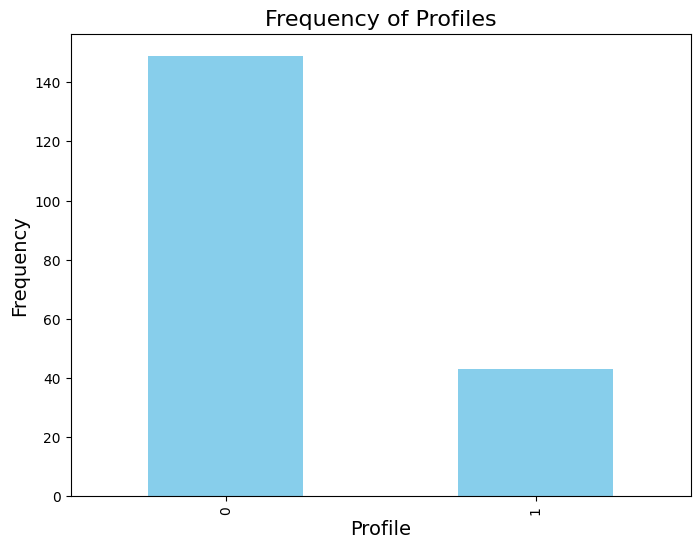

In [38]:
edge_df_low = edge_df[edge_df['binary_label'] == 0.0]
edge_df_high = edge_df[edge_df['binary_label'] == 1.0]

print('Number of low-cohesion edges: ', len(edge_df_low))
plot_label_hist(edge_df_low)
print('Number of high-cohesion edges: ', len(edge_df_high))
plot_label_hist(edge_df_high)

Now lets generate a GM for each type of edge and node profile to sample from when genearting artifical samples. 

In [39]:
from sklearn.mixture import GaussianMixture


gmm_nodes_by_profile = {}
gmm_edges_by_profile = {}

# --- Training GMMs for Node Profiles ---
for profile in node_df['profile'].unique():
    profile_node_df = node_df[node_df['profile'] == profile]
    
    # Extract the feature columns for GMM training
    X_profile = profile_node_df[node_features_columns].values
    gmm = GaussianMixture(n_components=1)
    gmm.fit(X_profile)
    gmm_nodes_by_profile[profile] = gmm

# --- Training GMMs for Edge Profiles ---
for profile in edge_df['profile'].unique():
    profile_edge_df = edge_df[edge_df['profile'] == profile]
    
    # Extract the feature columns for GMM training
    X_profile_edges = profile_edge_df[edge_features_columns].values 
    gmm = GaussianMixture(n_components=1)  
    gmm.fit(X_profile_edges)
    
    # Store the GMM in the dictionary
    gmm_edges_by_profile[profile] = gmm


In [40]:
import pandas as pd
import numpy as np

def generate_samples(n_df, e_df, gmm_nodes_by_profile, gmm_edges_by_profile, num_samples=10):
    generated_nodes = pd.DataFrame()
    generated_edges = pd.DataFrame()

    # Group the node_df by 'meeting' and 'start'
    node_groups = n_df.groupby(['Meeting', 'Start'])
    print('Number of Groups Being Used as Training Base: ', len(node_groups))

    # Set initial generation number
    generation_number = 1

    for (meeting, start), node_group in node_groups:
        node_group = node_group.reset_index(drop=True)
        # Find the corresponding edge group in edge_df with the same 'meeting' and 'start'
        edge_group = e_df[(e_df['Meeting'] == meeting) & (e_df['Start'] == start)]
        edge_group = edge_group.reset_index(drop=True)
        
        if edge_group.empty:
            continue  # Skip if no matching edge group is found
        
        # Generate nodes and edges based on their profile group
        for _ in range(num_samples):  # Generate a specified number of samples (default 10)
            # --- Generating node samples ---
            node_sample = node_group.copy()

            for j, profile in enumerate(node_sample['profile']):
                # Use the GMM corresponding to the profile to generate new features
                gmm_for_node_profile = gmm_nodes_by_profile[profile]  
                # Generate new node features with randomness
                new_node_features = gmm_for_node_profile.sample(1)[0]
                # Apply a post-processing step to remove negative values
                new_node_features = np.clip(new_node_features, 0, None)  # Set negative values to 0
                # Replace node features in the sample DataFrame
                node_sample.loc[j, node_features_columns] = new_node_features

            # Assign a generation number to the node sample
            node_sample['generation_number'] = generation_number
            
            # --- Generating edge samples ---
            edge_sample = edge_group.copy()

            for k, profile in enumerate(edge_sample['profile']):
                # Use the GMM corresponding to the edge profile to generate new features
                gmm_for_edge_profile = gmm_edges_by_profile[profile]  
                # Generate new edge features with randomness
                new_edge_features = gmm_for_edge_profile.sample(1)[0]  # Generate new edge features
                # Apply a post-processing step to remove negative values
                new_edge_features = np.clip(new_edge_features, 0, None)  # Set negative values to 0
                # Replace edge features in the sample DataFrame
                edge_sample.loc[k, edge_features_columns] = new_edge_features
            # Assign a generation number to the edge sample
            edge_sample['generation_number'] = generation_number

            # Append the generated node and edge samples to the final DataFrames
            generated_nodes = pd.concat([generated_nodes, node_sample], ignore_index=True)
            generated_edges = pd.concat([generated_edges, edge_sample], ignore_index=True)
            
            # Increment the generation number
            generation_number += 1

    # Return the generated DataFrames
    print("Number of Generated Nodes: ", len(generated_nodes))
    print("Number of Generated Edges (Should be equal to Number of Nodes * 3): ", len(generated_edges))
    return generated_nodes, generated_edges


In [41]:

num_0s = len([train for train in training_base if train['score'] == 0.0])
num_1s = len([train for train in training_base if train['score'] == 1.0])
ratio_high_low = float(num_1s) / float(num_0s)

num_samples_low = 20
num_samples_high = 20
if ratio_high_low > 1.0:
    num_samples_low = int(num_samples_high * (ratio_high_low))
elif ratio_high_low < 1.0:
    num_samples_high = int((1/ratio_high_low) * (num_samples_low))

print("Number of samples generated for each high-cohesion meeting:", num_samples_high )
print("Number of samples generated for each low-cohesion meeting:", num_samples_low)

Number of samples generated for each high-cohesion meeting: 21
Number of samples generated for each low-cohesion meeting: 20


In [42]:
high_cohesion_node_gen, high_cohesion_edge_gen = generate_samples(node_df_high, edge_df_high, gmm_nodes_by_profile, gmm_edges_by_profile, num_samples=num_samples_high )

Number of Groups Being Used as Training Base:  16
Number of Generated Nodes:  1344
Number of Generated Edges (Should be equal to Number of Nodes * 3):  4032


In [43]:
low_cohesion_node_gen, low_cohesion_edge_gen = generate_samples(node_df_low, edge_df_low, gmm_nodes_by_profile, gmm_edges_by_profile, num_samples=num_samples_low)

Number of Groups Being Used as Training Base:  17
Number of Generated Nodes:  1360
Number of Generated Edges (Should be equal to Number of Nodes * 3):  4080


lets now recreate the graphs in their original dictionary form 

In [44]:
import pandas as pd

def create_feature_list(node_df, edge_df):
    feature_list = []

    node_groups = node_df.groupby(['Meeting', 'Start', 'generation_number'])
    
    for (meeting, start, _), node_group in node_groups:
        # Find the corresponding edge group
        edge_group = edge_df[(edge_df['Meeting'] == meeting) & (edge_df['Start'] == start)]
        
        if edge_group.empty:
            continue 
        
        node_features = {}
        edge_features = {}
        # Iterate over the nodes (A, B, C, D)
        for _, node_row in node_group.iterrows():
            speaker = node_row['speaker']
            features = [
                ('time_portion', node_row['time_portion']),
                ('speaking_turns_proportion', node_row['speaking_turns_proportion']),
                ('rate_of_speech', node_row['rate_of_speech']),
                ('lexical_richness', node_row['lexical_richness']),
                ('positive_sentiment_proportion', node_row['positive_sentiment_proportion']),
                ('negative_sentiment_proportion', node_row['negative_sentiment_proportion']),
                ('average_word_rarity', node_row['average_word_rarity']),
                ('first_person_pronoun_usage', node_row['first_person_pronoun_usage']),
                ('second_person_pronoun_usage', node_row['second_person_pronoun_usage']),
                ('third_person_pronoun_usage', node_row['third_person_pronoun_usage']),
                ('agreement_words_proportion', node_row['agreement_words_proportion']),
                ('disagreement_words_proportion', node_row['disagreement_words_proportion'])
            ]
            node_features[speaker] = features
        
        # Iterate over the edges and add the edge features
        for _, edge_row in edge_group.iterrows():
            speaker = edge_row['speaker']
            speaker_target = edge_row['speaker_target']
            edge_key = f'{speaker},{speaker_target}' 
            features = [
                ('LSM', edge_row['LSM']),
                ('interruptions', edge_row['interruptions']),
                ('average_turns_between', edge_row['average_turns_between'])
            ]
            edge_features[edge_key] = features
        
        generation_id = node_group['generation_number'].iloc[0]  
        cohesion_label_val = node_group['binary_label'].iloc[0]  
        # Create the final dictionary for the current group
        group_dict = {
            'meeting': meeting,
            'start': start,
            'features': (node_features, edge_features),
            'score': cohesion_label_val,
            'generationID': generation_id
        }
        
        feature_list.append(group_dict)
    
    return feature_list

# Generate the feature lists for high and low cohesion
high_cohesion_graphs = create_feature_list(high_cohesion_node_gen, high_cohesion_edge_gen)
low_cohesion_graphs = create_feature_list(low_cohesion_node_gen, low_cohesion_edge_gen)

combined_cohesion_graphs = high_cohesion_graphs + low_cohesion_graphs

# Print the first element as an example
print(f"Number of Generated Graphs (Should be {(num_0s * num_samples_low) + (num_1s * num_samples_high)}): {len(combined_cohesion_graphs)}")


Number of Generated Graphs (Should be 676): 676


In [45]:
import pickle

# Assuming 'graphs' is your list of graph data
with open('data/graphs_cohesion_data_artificial_gen.pkl', 'wb') as f:
    pickle.dump(combined_cohesion_graphs, f)